In [29]:
import torch
import torchvision
from torchvision import datasets, transforms
from PIL import Image, ImageGrab, ImageTk, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
import os

print(torch.__version__)

2.0.1


In [30]:
# Custom Paired Dataset Class

class PairedDataset(torch.utils.data.Dataset):
    def __init__(self, lowres_folder, highres_folder, transform=None):
        self.lowres_folder = lowres_folder
        self.highres_folder = highres_folder
        self.transform = transform
        # Assuming file names in both folders are the same and in order.
        self.filenames = [f for f in os.listdir(lowres_folder) if os.path.isfile(os.path.join(lowres_folder, f))]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        lowres_path = os.path.join(self.lowres_folder, self.filenames[idx])
        highres_path = os.path.join(self.highres_folder, self.filenames[idx])

        lowres_image = Image.open(lowres_path).convert('RGB')
        highres_image = Image.open(highres_path).convert('RGB')

        if self.transform is not None:
            lowres_image = self.transform(lowres_image)
            highres_image = self.transform(highres_image)

        return lowres_image, highres_image

### Loading the Data

In [31]:
# Transform into tensors

transform = transforms.Compose([
    transforms.Resize((255, 255)),
    transforms.ToTensor(),
])

data_path = "data_final/"
dataset = PairedDataset(lowres_folder= f"{data_path}/lowres", highres_folder=f"{data_path}/highres", transform=transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size= 32, shuffle = True)

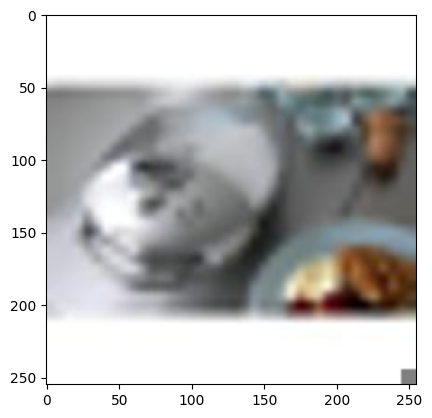

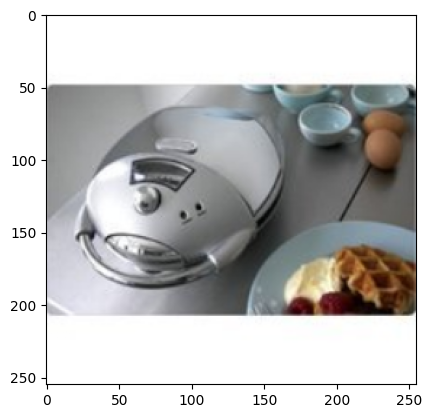

In [32]:
# Make sure images are correct
def imshow(img_tensor):
    # Convert from tensor to numpy array
    np_img = img_tensor.numpy()
    # Change from (C, H, W) to (H, W, C) for visualization
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

# Get a batch of images and labels
data_iter = iter(data_loader)
paired_images = next(data_iter)

lowres_images, highres_images = paired_images

# Visualize images in the batch
imshow(lowres_images[0])  # Low-res image
imshow(highres_images[0])  # High-res image

In [33]:
# Split the dataset into train and validation
train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])

print(f"Total Images: {2 * len(dataset)}")
print(f"Training Images: {2 * len(train_dataset)}")
print(f"Validation Images: {2 * len(valid_dataset)}")


Total Images: 2274
Training Images: 1818
Validation Images: 456


## SRCNN

In [34]:
import torch.nn as nn
import torch.nn.functional as F

In [35]:
# SRCNN

class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.layer1 = nn.Conv2d(3, 64, kernel_size=9, padding=4)  # Patch extraction
        self.layer2 = nn.Conv2d(64, 32, kernel_size=1, padding=0)  # Non-linear mapping
        self.layer3 = nn.Conv2d(32, 3, kernel_size=5, padding=2)   # Reconstruction

    def forward(self, x):
        x = nn.functional.relu(self.layer1(x))
        x = nn.functional.relu(self.layer2(x))
        x = self.layer3(x)
        return x

model = SRCNN()


### Loss Function and Optimizer

In [36]:
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.001)

### Train the Model

In [10]:
epochs = 64
print(len(data_loader))

for epoch in range(epochs):
    model.train()
    counter = 0
    for paired_images in data_loader:
        counter += 1
        if (counter % 100 == 0):
            print(f" I have processed, {counter} images, and I am on epoch {epoch}")
        lowres_image, highres_image = paired_images
        lowres_image = lowres_image[0]
        highres_image = highres_image[0]

        optimizer.zero_grad()
        output = model(lowres_images)

        loss = criterion(output, highres_image)
        loss.backward()
        optimizer.step()
    
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')
    try:
        torch.save(model.state_dict(), 'trained_models/model_epoch_{}.pth'.format(epoch+1))
    except:
        continue

torch.save(model, "trained_models/SRCNN.pth")



36


/opt/homebrew/Caskroom/miniconda/base/envs/3.10/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3, 255, 255])) that is different to the input size (torch.Size([32, 3, 255, 255])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/64, Loss: 0.1116190105676651
Epoch 2/64, Loss: 0.05878322571516037
Epoch 3/64, Loss: 0.13986451923847198
Epoch 4/64, Loss: 0.07635750621557236
Epoch 5/64, Loss: 0.08369065076112747
Epoch 6/64, Loss: 0.1752401888370514
Epoch 7/64, Loss: 0.16447509825229645
Epoch 8/64, Loss: 0.06461472064256668
Epoch 9/64, Loss: 0.15734022855758667
Epoch 10/64, Loss: 0.16481736302375793
Epoch 11/64, Loss: 0.06786587834358215
Epoch 12/64, Loss: 0.10397608578205109
Epoch 13/64, Loss: 0.06411594152450562
Epoch 14/64, Loss: 0.06201877444982529
Epoch 15/64, Loss: 0.0955551415681839
Epoch 16/64, Loss: 0.08418059349060059
Epoch 17/64, Loss: 0.06098205968737602
Epoch 18/64, Loss: 0.07416374981403351
Epoch 19/64, Loss: 0.07726086676120758
Epoch 20/64, Loss: 0.06975321471691132
Epoch 21/64, Loss: 0.07895020395517349
Epoch 22/64, Loss: 0.08048200607299805
Epoch 23/64, Loss: 0.13245142996311188
Epoch 24/64, Loss: 0.19574709236621857
Epoch 25/64, Loss: 0.11272932589054108
Epoch 26/64, Loss: 0.0820126160979271

## SRGAN

In [37]:
class RRDB(nn.Module):
    def __init__(self, channels = 64, growth_rate = 32):
        super(RRDB, self).__init__()
        self.layer1 = nn.Conv2d(channels, growth_rate, kernel_size= 3, padding=1)
        self.layer2 = nn.Conv2d(channels + growth_rate, growth_rate, kernel_size=3, padding=1)
        self.layer3 = nn.Conv2d(channels + 2 * growth_rate, growth_rate, kernel_size=3, padding=1)
        self.layer4 = nn.Conv2d(channels + 3 * growth_rate, channels, kernel_size=3, padding=1)
    
    def forward(self, x):
        residual = x

        out = nn.functional.relu(self.layer1(x))
        out = nn.functional.relu(self.layer2(torch.cat([out, x], 1)))
        out = nn.functional.relu(self.layer3(torch.cat([out, x], 1)))
        out = self.layer4(torch.cat([out, x], 1))

        return residual + out

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.initial_layer = nn.Conv2d(3, 64, kernel_size=3, padding=1)

        self.rrdb1 = RRDB()
        self.rrdb2 = RRDB()
        self.rrdb3 = RRDB()

        self.final_layer = nn.Conv2d(64, 3, kernel_size=3, padding=1)
    
    def forward(self, x):
        x = nn.functional.relu(self.initial_layer(x))

        x = self.rrdb1(x)
        x = self.rrdb2(x)
        x = self.rrdb3(x)

        x = self.final_layer(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        def discriminator_block(in_channels, out_channels, normalization=True):
            layers = [nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1)]
            if normalization:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(3, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.final_shit = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )
    
    def forward(self, img):
        out = self.model(img)
        print("Shape before final layers:", out.shape)  # Add this print statement
        out = out.view(out.size(0), -1)  # Flatten the output correctly
        out = self.final_shit(out)
        return out.squeeze()

generator = Generator()
discriminator = Discriminator()

### Loss Functions & Optimizers

In [40]:
g_adversarial_loss = torch.nn.BCELoss()
d_adversarial_loss = torch.nn.BCELoss()

optimizer_g = torch.optim.AdamW(generator.parameters(), lr = 0.001)
optimizer_d = torch.optim.AdamW(discriminator.parameters(), lr = 0.001)


### Train the Model

In [ ]:
epochs = 1

for epoch in range(epochs):
    for lowres_image, highres_image in data_loader:
        # Labels for true and false
        batch_size = highres_image.size(0)
        real_labels = torch.ones(batch_size)
        fake_labels = torch.zeros(batch_size)

        optimizer_d.zero_grad()
        optimizer_g.zero_grad()

        # Train the optimizer
        # Find probability distribution of ground truth, and calculate loss between 1
        highres_output = discriminator(highres_image).squeeze()
        discriminator_loss = d_adversarial_loss(highres_output, real_labels)

        # Generate high res image from low res image and 
        predicted_highres_imgs = generator(lowres_image)
        predicted_output = discriminator(predicted_highres_imgs).squeeze()

        discriminator_loss.backward()
        optimizer_d.step()

        # Train the generator
        pred_output = discriminator(predicted_highres_imgs)
        generator_loss = g_adversarial_loss(pred_output, fake_labels)

        generator_loss.backward()
        optimizer_g.step()
    
    print(f"Epoch [{epoch + 1}/{epochs}], D Loss: {discriminator_loss.item()}, G Loss: {generator_loss.item()}")


